# Demond Forecasts for HERON datasets

## HERON Parking

### Load data

In [1]:
import pandas as pd
from sklearn import tree
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


In [2]:
ts60 = pd.read_csv('EVB-P1941076_Heron_Parking_mean_demand_20210102_to_20211013_60min.csv', index_col=0, parse_dates=True)


ts60.shape

(6673, 1)

In [3]:
features60 = pd.read_csv('EVB-P1941076_Heron_Parking_mean_demand_20210102_to_20211013_60min_time_covariates.csv', index_col=0, parse_dates=True)

In [4]:
features60.shape

(6673, 11)

In [5]:
df60 = ts60.join(features60)

In [6]:
df60.head()
df60.tail()

,Total Demand (kw),year,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,dayofweek,dayofyear,week,holidays
2021-10-12 20:00:00,0.000000,2021.0,-0.866025,0.5,0.0,1.0,-0.866025,0.500000,1.0,285.0,41.0,0.0
2021-10-12 21:00:00,0.000000,2021.0,-0.866025,0.5,0.0,1.0,-0.707107,0.707107,1.0,285.0,41.0,0.0
2021-10-12 22:00:00,0.000000,2021.0,-0.866025,0.5,0.0,1.0,-0.500000,0.866025,1.0,285.0,41.0,0.0
2021-10-12 23:00:00,0.000000,2021.0,-0.866025,0.5,0.0,1.0,-0.258819,0.965926,1.0,285.0,41.0,0.0
2021-10-13 00:00:00,-0.213913,2021.0,-0.866025,0.5,0.0,1.0,0.000000,1.000000,2.0,286.0,41.0,0.0


In [7]:
df60['prev_demand'] = df60['Total Demand (kw)'].shift(1)
df60['prev_demand2'] = df60['Total Demand (kw)'].shift(2)
df60['prev_demand3'] = df60['Total Demand (kw)'].shift(3)
df60['prev_demand4'] = df60['Total Demand (kw)'].shift(4)
# df60['prev_demand5'] = df60['Total Demand (kw)'].shift(5)
# df60['prev_demand6'] = df60['Total Demand (kw)'].shift(6)
# df60['prev_demand7'] = df60['Total Demand (kw)'].shift(7)
# df60['prev_demand8'] = df60['Total Demand (kw)'].shift(8)
# df60['prev_demand9'] = df60['Total Demand (kw)'].shift(9)
# df60['prev_demand10'] = df60['Total Demand (kw)'].shift(10)

df60['yesterday_demand'] = df60['Total Demand (kw)'].shift(24)

df60 = df60.dropna()
df60.head(5)

,Total Demand (kw),year,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,dayofweek,dayofyear,week,holidays,prev_demand,prev_demand2,prev_demand3,prev_demand4,yesterday_demand
2021-01-09 00:00:00,0.0,2021.0,0.5,0.866025,0.0,1.0,0.000000,1.000000,5.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-09 01:00:00,0.0,2021.0,0.5,0.866025,0.0,1.0,0.258819,0.965926,5.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-09 02:00:00,0.0,2021.0,0.5,0.866025,0.0,1.0,0.500000,0.866025,5.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-09 03:00:00,0.0,2021.0,0.5,0.866025,0.0,1.0,0.707107,0.707107,5.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-09 04:00:00,0.0,2021.0,0.5,0.866025,0.0,1.0,0.866025,0.500000,5.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


 ### Regression models for demand forecasting

#### Split to train and test set with the last 12 days to constitute the test set

In [9]:
y = df60[['Total Demand (kw)']]
X = df60[['prev_demand', 'prev_demand2', 'prev_demand3', 'prev_demand4', 'yesterday_demand', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dayofweek', 'dayofyear', 'holidays']]

In [12]:
X_train = X[:-(12*24)]
y_train = y[:-(12*24)]

X_test = X[-(12*24):]
y_test = y[-(12*24):]

#### Decision Tree Regression

In [13]:
tree_reg = tree.DecisionTreeRegressor()
tree_reg = tree_reg.fit(X_train, y_train)

y_train_pred_dec_tree = tree_reg.predict(X_train)
y_test_pred_dec_tree = tree_reg.predict(X_test)

In [14]:
MSE_train_dec_tree = mean_squared_error(y_train, y_train_pred_dec_tree)
MSE_test_dec_tree = mean_squared_error(y_test, y_test_pred_dec_tree)

print(MSE_test_dec_tree)

0.5689200291143925


MSE naive: 0.12788759426924518
MSE: 0.5689200291143925
RMSE: 0.7542678762312449


<Figure size 432x288 with 0 Axes>

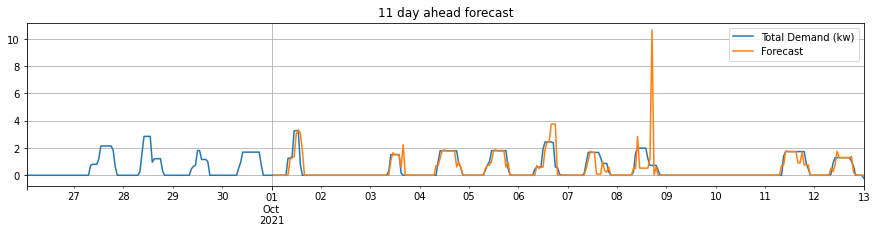

In [15]:
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
import matplotlib.pyplot as plt


ground_truth_line = pd.concat([y_train[-5*24:], y_test])

naive_pred = [y_train.to_numpy().tolist()[-1]] + y_test.to_numpy().tolist()[:-1]
print("MSE naive:", mse(y_test, naive_pred))
print("MSE:", mse(y_test, y_test_pred_dec_tree))
print("RMSE:", np.sqrt(mse(y_test, y_test_pred_dec_tree)))

plt.figure()
plot = ground_truth_line.plot(figsize=(15, 3), label='Data', legend=True, title="11 day ahead forecast")
a = pd.Series(y_test_pred_dec_tree)
a.index = pd.Series(y_test['Total Demand (kw)']).index
a.plot(label='Forecast', legend=True)
plot.grid()
plt.show()

#### SVM Baseline model

In [17]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

sv_regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
sv_regr.fit(X_train, y_train)

y_train_pred_svr = sv_regr.predict(X_train)
y_test_pred_svr = sv_regr.predict(X_test)

C:\Users\vkarakolis.EPU\Anaconda3\envs\veolia\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [18]:
MSE_test_svr = mean_squared_error(y_test, y_test_pred_svr)

print(MSE_test_svr)

0.10996512510794412


MSE naive: 0.12788759426924518
MSE: 0.10996512510794412
RMSE: 0.3316098989896775


<Figure size 432x288 with 0 Axes>

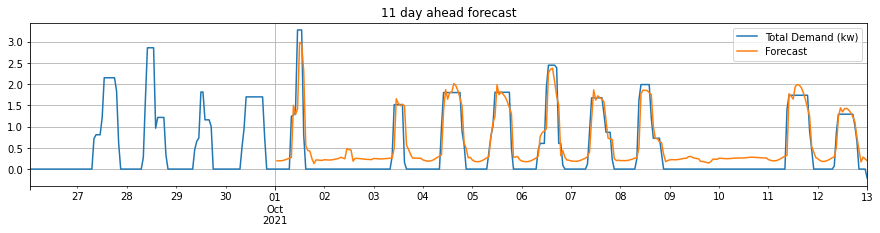

In [19]:
ground_truth_line = pd.concat([y_train[-5*24:], y_test])

naive_pred = [y_train.to_numpy().tolist()[-1]] + y_test.to_numpy().tolist()[:-1]
print("MSE naive:", mse(y_test, naive_pred))
print("MSE:", mse(y_test, y_test_pred_svr))
print("RMSE:", np.sqrt(mse(y_test, y_test_pred_svr)))

plt.figure()
plot = ground_truth_line.plot(figsize=(15, 3), label='Data', legend=True, title="11 day ahead forecast")
a = pd.Series(y_test_pred_svr)
a.index = pd.Series(y_test['Total Demand (kw)']).index
a.plot(label='Forecast', legend=True)
plot.grid()
plt.show()

#### Random forest regression

In [20]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()
rf_reg = rf_reg.fit(X_train, y_train)

y_train_pred_rf = rf_reg.predict(X_train)
y_test_pred_rf = rf_reg.predict(X_test)

<ipython-input-20-156f1dc969f9>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg = rf_reg.fit(X_train, y_train)


In [21]:
MSE_train_rf = mean_squared_error(y_train, y_train_pred_rf)
MSE_test_rf = mean_squared_error(y_test, y_test_pred_rf)

print(MSE_test_rf)

0.17681524290704867


MSE naive: 0.12788759426924518
MSE: 0.17681524290704867
RMSE: 0.4204940462206911


<Figure size 432x288 with 0 Axes>

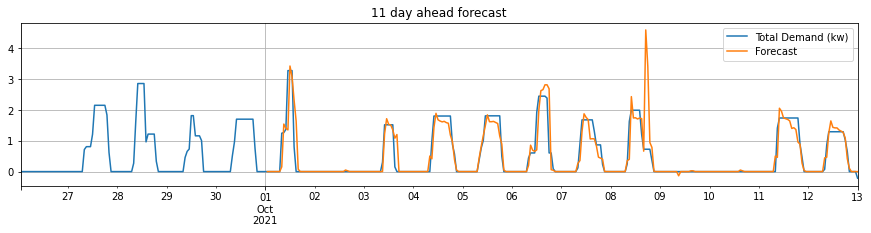

In [22]:
ground_truth_line = pd.concat([y_train[-5*24:], y_test])

naive_pred = [y_train.to_numpy().tolist()[-1]] + y_test.to_numpy().tolist()[:-1]
print("MSE naive:", mse(y_test, naive_pred))
print("MSE:", mse(y_test, y_test_pred_rf))
print("RMSE:", np.sqrt(mse(y_test, y_test_pred_rf)))

plt.figure()
plot = ground_truth_line.plot(figsize=(15, 3), label='Data', legend=True, title="11 day ahead forecast")
a = pd.Series(y_test_pred_rf)
a.index = pd.Series(y_test['Total Demand (kw)']).index
a.plot(label='Forecast', legend=True)
plot.grid()
plt.show()

### XGBoost

In [23]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)

y_test_pred_xgb = xgb_reg.predict(X_test)

In [24]:
MSE_test_xgb = mean_squared_error(y_test, y_test_pred_xgb)

print(MSE_test_xgb)

0.11125255462395825


MSE naive: 0.12788759426924518
MSE: 0.11125255462395825
RMSE: 0.3335454311243946


<Figure size 432x288 with 0 Axes>

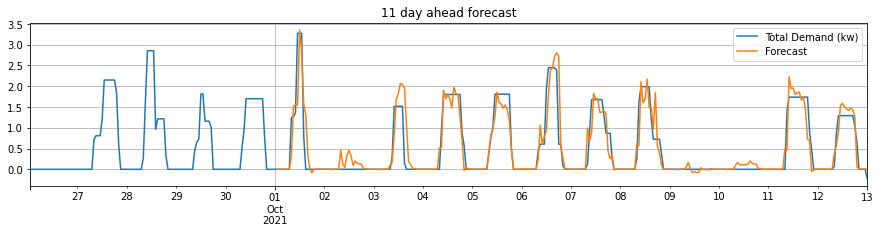

In [25]:
ground_truth_line = pd.concat([y_train[-5*24:], y_test])

naive_pred = [y_train.to_numpy().tolist()[-1]] + y_test.to_numpy().tolist()[:-1]
print("MSE naive:", mse(y_test, naive_pred))
print("MSE:", mse(y_test, y_test_pred_xgb))
print("RMSE:", np.sqrt(mse(y_test, y_test_pred_xgb)))

plt.figure()
plot = ground_truth_line.plot(figsize=(15, 3), label='Data', legend=True, title="11 day ahead forecast")
a = pd.Series(y_test_pred_xgb)
a.index = pd.Series(y_test['Total Demand (kw)']).index
a.plot(label='Forecast', legend=True)
plot.grid()
plt.show()